# [Workshop: Software Tools from Atomistics to Phase Diagrams](https://workshop.materialsgenomefoundation.org) 


## Day 1 - Atomistic simulations ([pyiron](https://pyiron.org))
**Authors:  <u>Jan Janssen</u>, Tilmann Hickel, Jörg Neugebauer ([Max-Planck-Institut für Eisenforschung](https://www.mpie.de))**

Interactive: **Creating atomistic structures with pyiron**

The scope of this first exercise is to become familar with:
* the jupyter notebook environment, 
* the pyiron project object and 
* the creation of atomistic structures.

## Reminder
Keyboard Shortcuts used in this tutorial
* `<tab>` - auto completion 
* `<tab> + <shift>` - documentation
* `<shift> + <enter>` - execute cell
* `<esc> + <a>` - new cell above
* `<esc> + <b>` - new cell below

## Getting Started 
Let's start by creating the first pyiron Project:

In [1]:
# Import the Project object
from pyiron import Project

In [2]:
# Create a Project object instance for a project 
# named atomistics
pr = Project("atomistics")

In [3]:
# The Project object instance, or Project for short 
# created a new folder in your current directory: 
pr.path

'/home/jovyan/again/atomistics/'

## The Project Object
The project object is the central object of the workflow management in pyiron. It can be used to:
* create atomistic structure objects
* create different kinds of atomistic simulation jobs
* track the execution of job objects locally and on remote HPC clusters. 

All these features are discussed in the following. For now we focus on the creation of atomistic structures from the project object. 

### Atomistic Structures
We start by creating a primitive fcc aluminium lattice using the ASE interface:

In [4]:
# Create a primitive aluminium (Al) fcc lattice: 
al_fcc = pr.create_ase_bulk("Al")
al_fcc

Al: [0. 0. 0.]
pbc: [ True  True  True]
cell: 
Cell([[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]])

In [5]:
# Create a cubic aluminium (Al) fcc lattice: 
al_fcc_cubic = pr.create_ase_bulk("Al", cubic=True)

# Visualise the cubic aluminium structure using NGLview: 
al_fcc_cubic.plot3d()

NGLWidget()

Based on the atomistic simulation environment (ASE) pyiron can create atomistic structures with minimal inputs. Still it is also possible to define all details manually: 

In [6]:
# Create a cubic aluminium (Al) bcc lattice:
al_bcc_cubic = pr.create_ase_bulk("Al", crystalstructure="bcc", a=3.2, cubic=True)

# Compare the number of atoms (length of the structure object) 
# in the bcc lattice (2) and the fcc lattice (4):
len(al_bcc_cubic), len(al_fcc_cubic)

(2, 4)

### Replacing atoms
While unary systems are still interesting from an academic perspective, the goal of this workshop is to calculate phase diagrams, so we are interested in alloys. 

In [7]:
# Create a copy of the cubic aluminium fcc structure:
al_ni_fcc_cubic = al_fcc_cubic.copy()

In [8]:
# Replace the first aluminium atom with an nickle (Ni) atom: 
al_ni_fcc_cubic[0] = "Ni"

# Visualise the updated structure: 
al_ni_fcc_cubic.plot3d()

NGLWidget()

### Beyond ASE - Atomic Neighbors 
https://wiki.fysik.dtu.dk/ase/ase/build/build.html
While the ASE atoms class already provides extensive functionality to build complex structures. pyiron extends the atoms class for example by adding specialized functionality like analysing the neighbour environment:  

In [9]:
# Repeat the cubic aluminium structure 5 times in each direction: 
al_large = al_fcc_cubic.repeat(5)

In [10]:
# Create the neighbor environment for the cubic aluminium structure, 
# by limiting the number of neighbors to 1000: 
al_large_neighbors = al_large.get_neighbors(num_neighbors=1000)

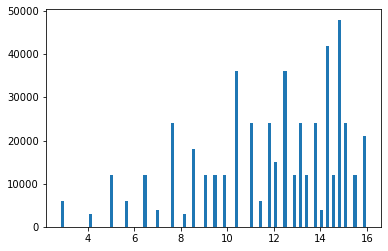

In [11]:
# Import the matplotlib library for plotting.
import matplotlib.pyplot as plt

# Visualise the per atom neighbour distances as historgram 
# with 100 bins: 
plt.hist(al_large_neighbors.distances.flatten(), bins=100);

## Special Quasi-random Structures
Rather than replacing individual atoms one by one special quasi-random structures are used to have the most random configuration for a given concentration. More details about this method are available in the literature: 
https://doi.org/10.1103/PhysRevLett.65.353

In [12]:
# Create an SQS calculation job from the project object 
# named "sqscalculation" : 
job_sqs = pr.create_job(
    job_type=pr.job_type.SQSJob, 
    job_name="sqscalculation"
)

In [13]:
# assign the large cubic aluminium fcc structure to the job object: 
job_sqs.structure = al_large 

In [14]:
# Print the input
job_sqs.input

InputList({'mole_fractions': {}, 'weights': None, 'objective': 0.0, 'iterations': 1000000.0, 'n_output_structures': 1})

In [15]:
# Set the Aluminium Nickel concentration to 50:50: 
job_sqs.input.mole_fractions = {"Al": 0.5, "Ni":0.5}

# Limit the number of iterations to 1000
job_sqs.input.iterations = 1000

In [16]:
# Execute the SQS calculation by calling the run function 
# of the job object: 
job_sqs.run()

The job sqscalculation was saved and received the ID: 74
Threads used: 1


In [17]:
# Display the first resulting structure 
job_sqs.list_structures()[0].plot3d()

NGLWidget()

## Managing your pyiron project
In contrast to the ASE functions which can be executed nearly instantaneous the calculation of the SQS structure requires multiple iterations and is therefore implemented as pyiron job. The same `create_job()` function is used in the following to create other atomistic simulations. Still before doing so we want to use the projecct object to inspect the calculation in the project: 

In [18]:
# Display the table of all jobs in the current 
# project by calling the job_table function: 
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,74,finished,Al500,sqscalculation,/sqscalculation,/home/jovyan/,again/atomistics/,2020-11-09 23:36:21.096449,2020-11-09 23:36:22.060374,0.0,pyiron@jupyter-jan#1,SQSJob,0.1,None,None


In [19]:
# Reload the job once based on it's database ID 
# using the job_id property:
job_reload_job_id = pr.load(job_sqs.job_id)

# and once using the job_name property of the job object: 
job_reload_job_name = pr.load(job_sqs.job_name)

In [20]:
# Compare the job name of both jobs: 
job_reload_job_id.job_name == job_reload_job_name.job_name

True

## Modify SQS-calculation job
By default pyiron is reloading existing calculations, rather than executing the same calculation again. Therefore to change the concentration of the SQS structure we set the `delete_existing_job` parameter for the `run()` function.

In [21]:
# Set the Aluminium Nickel concentration to 80:20. 
# The concentrations have to be given as floats ranging from 0 to 1:
job_sqs.input.mole_fractions = {"Al": 0.8, "Ni":0.2}

In [22]:
# Execute the SQS calculation by calling the run function 
# with the delete_existing parameter set to true: 
job_sqs.run(delete_existing_job=True)

This group does not exist in the HDF5 file sqscalculation
The job sqscalculation was saved and received the ID: 74
Threads used: 1


In [23]:
# Display the first resulting structure 
job_sqs.list_structures()[0].plot3d()

NGLWidget()

## Publications
Finally using an integrated framework like pyiron also allows us to collect all the publications of the tools we used in a given project, to keep track of the methods in use: 

In [24]:
# List publications used in the current project
pr.list_publications()

,author,title,journal,volume,pages,issn,doi,url,year,number,issue,numpages,month,publisher
0,"[Jan Janssen, Sudarsan Surendralal, Yury Lysogorskiy, Mira Todorova, Tilmann Hickel, Ralf Drautz, Jörg Neugebauer]",pyiron: An integrated development environment for computational materials science,Computational Materials Science,161,24 - 36,0927-0256,https://doi.org/10.1016/j.commatsci.2018.07.043,http://www.sciencedirect.com/science/article/pii/S0927025618304786,2019,NaN,NaN,NaN,NaN,NaN
1,"[Ask Hjorth Larsen, Jens Jørgen Mortensen, Jakob Blomqvist, Ivano E Castelli, Rune Christensen, Marcin Dułak, Jesper Friis, Michael N Groves, Bjørk Hammer, Cory Hargus, Eric D Hermes, Paul C Jenni...",The atomic simulation environment—a Python library for working with atoms,Journal of Physics: Condensed Matter,29,273002,NaN,NaN,http://stacks.iop.org/0953-8984/29/i=27/a=273002,2017,27,NaN,NaN,NaN,NaN
2,"[Zunger, A., Wei, S.-H., Ferreira, L.G., Bernard, J.E.]",Special quasirandom structures,Phys. Rev. Lett.,65,353,NaN,10.1103/PhysRevLett.65.353,https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.65.353,NaN,NaN,3,0,July,American Physical Society


## Summary 
At the end of this section you should be able to create pyiron projects, atomistic structures and calculation jobs. 

Additional exercises: 
* Create a vacancy using the `del` method. 
* Identify the coordinates of the vacancy automatically by calculating the nearest neighbor distance of all atoms.
* Replace the nearest neighbor atoms of the vacancy with a different element and visualise the structure using `plot3d()`. 